In [1]:
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import truncnorm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from numpy.polynomial import legendre
import pandas as pd
from datetime import datetime
from scipy.stats import multivariate_normal
from scipy.special import erf
from scipy.special import hyp1f1
from scipy.linalg import eigh
from random import randint
from scipy.optimize import fsolve
from scipy.optimize import root
from numpy.polynomial import legendre

In [2]:
rawdata = pd.read_csv("./crime-in-vancouver/crime.csv")

In [31]:
def training_data_extraction(year, N):
    training_data=[]
    for i in range(N):
        df_16=rawdata[rawdata['YEAR']==(year-i)]
        
        origin=pd.to_datetime(str(year-i)).value/10**9/86400/3   #convert to 3 days

        df_16=df_16[df_16['TYPE']=='Theft of Vehicle']

        df_16=df_16.loc[:,['YEAR','MONTH','DAY','HOUR','MINUTE']]

        df_16['dt']=pd.to_datetime(df_16)

        df_16['dt']=df_16['dt'].astype(np.int64)

        df_16=df_16.sort_values(['dt'])

        training_data_16=df_16['dt'].values/(10**9) # convert to second

        training_data_16=training_data_16/86400   # convert to day
        
        training_data_16=training_data_16/3   # convert to 3 days

        training_data_16=training_data_16-origin
        
        training_data_16=np.unique(training_data_16)
        training_data.append(training_data_16)
    return np.array(training_data)

In [32]:
training=training_data_extraction(2016,4)

In [39]:
T=122

In [40]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [41]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [42]:
def u_generate(theta0,theta1,xi): # xi is inducing points, N(0,Sigma)
    N=len(xi)
    cov=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov[j][i]=cov[i][j]
    return multivariate_normal([0]*N,cov).rvs(),np.array([0]*N),cov

In [144]:
T_phi=5

In [145]:
xi=np.linspace(0+(T_phi/5)/2,T_phi-(T_phi/5)/2,5)   # 5 inducing points on \phi(\tau)

In [146]:
xi_mu=np.linspace(0+T/8/2,T-T/8/2,8)   # 8 inducing points, T is larger so we need more points

In [147]:
theta0=0.01
theta1=6

In [148]:
u,mean_p_u,cov_p_u=u_generate(theta0,theta1,xi)

In [149]:
f=GP_regression(xi,u,theta0,theta1,0.000001,T_phi,100) # f is 100-dimension vector on [0,T_phi]

In [150]:
def eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,m):
    y=0
    s=p
    for i in range(1,len(k_K_k)):
        for j in range(i):
            if P[i][j]!=0:
                y+=k_K_K_k[i][j][m]*P[i][j]/(k_K_k[i][j]+sum([(k_K[i][j][k]**2)*s[k] for k in range(M)]))
    y+=-secondterm[m]-0.5*thirdterm[m]+0.5/s[m]
    return y

In [50]:
def equations(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M):
    return [eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,i) for i in range(M)]

In [51]:
def ini_P(points_hawkes,T_phi):
    N=len(points_hawkes)
    P=np.zeros((N,N))
    for i in range(N):                    # initial value of P
        for j in range(i+1):
            tij=points_hawkes[i]-points_hawkes[j]
            if tij>=T_phi:continue
            else:
                P[i][j:i+1]=np.random.dirichlet([1]*(i-j+1))
                break
    return P

In [52]:
def psi(theta0,theta1,xn,xm,T):
    x_mean=(xn+xm)/2
    return (theta0**2)*(-np.sqrt(np.pi/theta1)/2)*np.exp((-theta1*(xn-xm)**2)/4)*(erf((x_mean-T)*np.sqrt(theta1))\
                                                                                  -erf(x_mean*np.sqrt(theta1)))

In [53]:
def distribution_f_posterior(x_f,xi,theta0,theta1,cov_p_u,cov_q_u_post):
    N=len(xi) # N is number of inducing points
    M=len(x_f) # M is number of predicting points
    
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    
    K_xz=np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            K_xz[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],xi[j])
#     K_xx=np.zeros((M,M))
#     for i in range(M):
#         for j in range(i,M):
#             K_xx[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],x_f[j])
#             K_xx[j][i]=K_xx[i][j]
#     mean_f=(K_xz.dot(cov_p_u_inv)).dot(mean_q_u_post)
#     cov_f=K_xx-(K_xz.dot(cov_p_u_inv)).dot(K_xz.T)+(((K_xz.dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz.T)
    var_f=np.array([theta0-K_xz[i].dot(cov_p_u_inv).dot(K_xz[i].T)+(((K_xz[i].dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz[i].T) for i in range(M)])
    
    exp_phi=var_f
    return exp_phi

In [151]:
theta0_mu=1
theta1_mu=0.01

In [152]:
u_mu,mean_p_u_mu,cov_p_u_mu=u_generate(theta0_mu,theta1_mu,xi_mu)

In [153]:
f_mu=GP_regression(xi_mu,u_mu,theta0_mu,theta1_mu,0.000001,T,500) # f is 1000-dimension vector on [0,T]

In [154]:
def eq_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,m):
    y=0
    s=p
    for n in range(len(k_K_k)):
        if P[n][n]!=0:
            y+=k_K_K_k[n][m]*P[n][n]/(k_K_k[n]+sum([(k_K[n][i]**2)*s[i] for i in range(M)]))
    y+=-secondterm[m]-0.5*thirdterm[m]+0.5/s[m]
    return y

In [155]:
def equations_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M):
    return [eq_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,i) for i in range(M)]

In [156]:
def MISD_variational_deri(points_hawkes,xi,xi_mu,T_phi,T,num_iter): # 100 predict points on T_phi, 1000 predict points on T
    N=len(points_hawkes) # num of observation
    M=len(xi)            # num of inducing points on phi
    M_mu=len(xi_mu)      # num of inducing points on mu
    P=ini_P(points_hawkes,T_phi)
    delta_t=T_phi/len(f[0]) # phi is discete to 100 points
    delta_t_mu=T/len(f_mu[0]) # u(t) is descrete to 500 points
    
    
    #_______________________initial setting of mu
    cov_q_u_mu_diag=np.random.uniform(0,1,M_mu)  ## initial of cov_q_u_mu_diag
    k_tn_z_mu=np.zeros((N,M_mu))
    for i in range(N):
        for j in range(M_mu):
            k_tn_z_mu[i][j]=expo_quad_kernel(theta0_mu,theta1_mu,points_hawkes[i],xi_mu[j])
            
    cov_p_u_mu_inv=np.linalg.inv(cov_p_u_mu)
    thirdterm_mu=np.diagonal(cov_p_u_mu_inv)
    Psi_mu=np.zeros((M_mu,M_mu))
    for i in range(M_mu):
        for j in range(i,M_mu):
            Psi_mu[i][j]=psi(theta0_mu,theta1_mu,xi_mu[i],xi_mu[j],T)
            Psi_mu[j][i]=Psi_mu[i][j]
    secondterm_mu=np.diagonal(cov_p_u_mu_inv.dot(Psi_mu).dot(cov_p_u_mu_inv))
    
    k_K_K_k_mu=np.empty((0,M_mu))   #vector of vector   #     1st term
    k_K_k_mu=np.array([])    # vecotr of value
    k_K_mu=np.empty((0,M_mu))      # vector of vector
    for i in range(N):
        k_K_K_k_mu=np.append(k_K_K_k_mu, np.array([np.diagonal(cov_p_u_mu_inv.dot(np.array([k_tn_z_mu[i]]).T).dot(np.array([k_tn_z_mu[i]])).dot(cov_p_u_mu_inv))]),axis=0)
        k_K_k_mu=np.append(k_K_k_mu,theta0_mu-k_tn_z_mu[i].dot(cov_p_u_mu_inv).dot(k_tn_z_mu[i].T))
        k_K_mu=np.append(k_K_mu,np.array([k_tn_z_mu[i].dot(cov_p_u_mu_inv)]),axis=0) 
    
    #__________________initial setting of phi
    cov_q_u_diag=np.random.uniform(0,1,M)
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    thirdterm=np.diagonal(cov_p_u_inv)
    n_1=sum(np.array(points_hawkes)<(T-T_phi)) # num of points within T-T_phi
    Psi=np.zeros((N,M,M))
    for i in range(n_1):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T_phi)
                Psi[i][k][j]=Psi[i][j][k]
    for i in range(n_1,N):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T-points_hawkes[i])
                Psi[i][k][j]=Psi[i][j][k]
    secondterm=sum([np.diagonal(cov_p_u_inv.dot(Psi[i]).dot(cov_p_u_inv)) for i in range(N)])
    k_tn_z=np.zeros((N,N,M))
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                tao=points_hawkes[i]-points_hawkes[j]
                k_tn_z[i][j]=np.array([expo_quad_kernel(theta0,theta1,tao,xi[k]) for k in range(M)])            
    k_K_K_k=np.zeros((N,N,M))   # matrix of vector   #     1st term
    k_K_k=np.zeros((N,N))    # matrix of value
    k_K=np.zeros((N,N,M))     # matrix of vector
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                k_K_K_k[i][j]=np.diagonal(cov_p_u_inv.dot(np.array([k_tn_z[i][j]]).T).dot(np.array([k_tn_z[i][j]])).dot(cov_p_u_inv))
                k_K_k[i][j]=theta0-k_tn_z[i][j].dot(cov_p_u_inv).dot(k_tn_z[i][j].T)
                k_K[i][j]=k_tn_z[i][j].dot(cov_p_u_inv)
    
    
    
    
    
    for k in range(num_iter):  # num of iterations
        # update of phi
        
        cov_q_u_diag=fsolve(equations,cov_q_u_diag, args=(P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M))
        cov_q_u_diag[cov_q_u_diag<0] = 0.1 # more stable
        cov_q_u=np.diag(cov_q_u_diag)
        phi=distribution_f_posterior(f[0],xi,theta0,theta1,cov_p_u,cov_q_u)
        
        # update of mu
        
        cov_q_u_mu_diag=fsolve(equations_mu,cov_q_u_mu_diag, args=(P,k_K_mu,k_K_k_mu,k_K_K_k_mu,secondterm_mu,thirdterm_mu,M_mu))
        cov_q_u_mu_diag[cov_q_u_mu_diag<0] = 0.1 # more stable
        cov_q_u_mu=np.diag(cov_q_u_mu_diag)
        mu=distribution_f_posterior(f_mu[0],xi_mu,theta0_mu,theta1_mu,cov_p_u_mu,cov_q_u_mu)

        
        for i in range(N): # updata of P
            mu_ti=mu[int(points_hawkes[i]/delta_t_mu)]
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: continue
                intensity_total+=phi[int(tji/delta_t)]
            intensity_total+=mu_ti
            P[i][i]=mu_ti/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: P[i][j]=0
                else: P[i][j]=phi[int(tji/delta_t)]/intensity_total
    return mu,phi

In [157]:
%%time
mu_var_multiple=[]
phi_var_multiple=[]
for i in range(1):
    mu_var,phi_var=MISD_variational_deri(training[i],xi,xi_mu,T_phi,T,20)
    mu_var_multiple.append(mu_var)
    phi_var_multiple.append(phi_var)

Wall time: 28min 57s


In [158]:
mu_var=np.average(np.array(mu_var_multiple),axis=0)
phi_var=np.average(np.array(phi_var_multiple),axis=0)

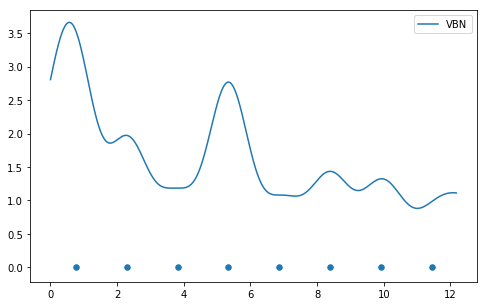

In [159]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(f_mu[0]/10,mu_var,label='VBN')
axs.scatter(xi_mu/10,np.zeros((len(xi_mu))),marker='o',s=30)
plt.legend()
plt.show()

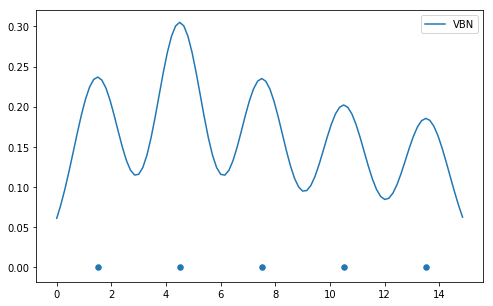

In [160]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(f[0]*3,phi_var,label='VBN')
axs.scatter(xi*3,np.zeros((len(xi))),marker='o',s=30)
plt.legend()
plt.show()

In [66]:
def MISD(points_hawkes,T,T_gamma,delta_t,num_iter):
    num_g=int(T_gamma/delta_t)
    N=len(points_hawkes)
    P=ini_P(points_hawkes,T_gamma)
    g=np.zeros((1,num_g), dtype=float)

    for k in range(num_iter):
        for m in range(num_g): # update for u and g
            rate_prob=np.zeros((1,N))
            div_num=0
            for i in range(N):
                if (T-points_hawkes[i])>=m*delta_t and (T-points_hawkes[i])<(m+1)*delta_t: # point i is close to T
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/(T-m*delta_t)
                elif (T-points_hawkes[i])<m*delta_t:
                    break
                else:
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/delta_t
            if div_num==0:
                break
            else:
                g[0][m]=sum(rate_prob[0])/div_num
        u=sum(P[i][i] for i in range(N))/T

        for i in range(N): # updata for P
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: continue
                intensity_total+=g[0][int(tji/delta_t)]
            intensity_total+=u
            P[i][i]=u/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: P[i][j]=0
                else: P[i][j]=g[0][int(tji/delta_t)]/intensity_total
    return u,g[0]

In [68]:
%%time
u_misd_5_multiple=[]
phi_misd_5_multiple=[]
for i in range(1):
    u_misd_5,phi_misd_5=MISD(training[i],T,T_phi,1,100)
    u_misd_5_multiple.append(u_misd_5)
    phi_misd_5_multiple.append(phi_misd_5)

Wall time: 2min 36s


In [69]:
u_misd_5=np.average(np.array(u_misd_5_multiple))
phi_misd_5=np.average(np.array(phi_misd_5_multiple),axis=0)

In [70]:
u_misd_5

5.44841028410627

In [82]:
%%time
u_misd_10_multiple=[]
phi_misd_10_multiple=[]
for i in range(1):
    u_misd_10,phi_misd_10=MISD(training[i],T,T_phi,0.5,100)
    u_misd_10_multiple.append(u_misd_10)
    phi_misd_10_multiple.append(phi_misd_10)

Wall time: 2min 11s


In [83]:
u_misd_10=np.average(np.array(u_misd_10_multiple))
phi_misd_10=np.average(np.array(phi_misd_10_multiple),axis=0)

In [84]:
u_misd_10

4.9384774993602063

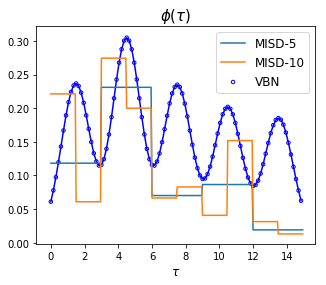

In [162]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot(f[0]*3,phi_var,'b')
axs.scatter(f[0]*3,phi_var,marker='o',s=12,c='',edgecolors='b',label='VBN')
axs.plot(np.linspace(0,5,300,endpoint=False)*3,[phi_misd_5[int(xxx/1)] for xxx in np.linspace(0,5,300,endpoint=False)],label='MISD-5')
axs.plot(np.linspace(0,5,300,endpoint=False)*3,[phi_misd_10[int(xxx/0.5)] for xxx in np.linspace(0,5,300,endpoint=False)],label='MISD-10')
# axs.plot(f[0]*10,phi_wh,label='WH')
plt.xlabel(r'$\tau$',fontsize=12)
plt.title(r'$\phi(\tau)$',fontsize=15)
# plt.xlim(0,60)
# plt.ylim(-0.05,1.2)
# plt.xticks(np.arange(0, 65, 10))
plt.legend(fontsize=12)

# plt.savefig('./phi_realdata_1',bbox_inches = 'tight')
plt.show()

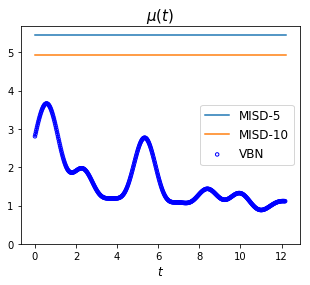

In [170]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot(f_mu[0]/10,mu_var,'b')
axs.scatter(f_mu[0]/10,mu_var,marker='o',s=12,c='',edgecolors='b',label='VBN')
axs.plot([0,T/10],[u_misd_5,u_misd_5],label='MISD-5')
axs.plot([0,T/10],[u_misd_10,u_misd_10],label='MISD-10')
# axs.plot([0,T/6],[u_wh,u_wh],label='WH')
plt.xlabel(r'$t$',fontsize=12)
plt.title(r'$\mu(t)$',fontsize=15)
plt.ylim(0)
# plt.xlim(0,24)
# plt.xticks(np.arange(0, 25, 2))
plt.legend(fontsize=12)

# plt.savefig('./mu_realdata_1',bbox_inches = 'tight')
plt.show()

In [74]:
def intensity_discrete(t,history,u,g_mean,T_phi):    #left continue, the intensity is a gaussian dist
    mu=u
    N=len(g_mean)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<T_phi:
            intensity_mean+=g_mean[int(delta_t*N/T_phi)]
    return mu+intensity_mean

In [75]:
def negtiveloglikelihood_discrete(u,g_mean,times,T_phi,T):
    N=len(times)
    M=len(g_mean)
    logl=0
    for i in range(N):
        logl+=np.log(intensity_discrete(times[i],times,u,g_mean,T_phi))
        delta_t=T-times[i]
        if delta_t>=T_phi:
            logl-=sum(g_mean*T_phi/M)
        else:
            temp=(delta_t)*M/T_phi
            temp_int=int(temp)
            logl-=sum(g_mean[:temp_int]*T_phi/M)+g_mean[temp_int]*T_phi/M*(temp-temp_int)
    return -(logl-u*T)

In [76]:
def intensity_discrete_phi_mu(t,history,u,g_mean,g_range,T):    #left continue
    mu=u
    N=len(g_mean)
    M=len(mu)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<g_range:
            intensity_mean+=g_mean[int(delta_t*N/g_range)]
    result=mu[int(t/T*M)]+intensity_mean
    return result

In [77]:
def negtiveloglikelihood_discrete_phi_mu(u,g_mean,g_range,times,T):
    N=len(times)
    M=len(g_mean)
    logl=0
    for i in range(N):
        logl+=np.log(intensity_discrete_phi_mu(times[i],times,u,g_mean,g_range,T))
        delta_t=T-times[i]
        if delta_t>=g_range:
            logl-=sum(g_mean*g_range/M)
        else:
            temp=(delta_t)*M/g_range
            temp_int=int(temp)
            logl-=sum(g_mean[:temp_int]*g_range/M)+g_mean[temp_int]*g_range/M*(temp-temp_int)
    return -(logl-sum(u*T/len(u)))

In [164]:
np.average([negtiveloglikelihood_discrete(u_misd_5,phi_misd_5,training[i],T_phi,T) for i in range(0,1)])

-2004.2133759224384

In [165]:
np.average([negtiveloglikelihood_discrete(u_misd_10,phi_misd_10,training[i],T_phi,T) for i in range(0,1)])

-2005.6999841463655

In [166]:
np.average([negtiveloglikelihood_discrete_phi_mu(mu_var,phi_var,T_phi,training[i],T) for i in range(0,1)])

-1989.9906007361976

In [167]:
np.average([negtiveloglikelihood_discrete(u_misd_5,phi_misd_5,training[i],T_phi,T) for i in range(1,2)])

-1792.2987949902822

In [168]:
np.average([negtiveloglikelihood_discrete(u_misd_10,phi_misd_10,training[i],T_phi,T) for i in range(1,2)])

-1792.5099597092296

In [169]:
np.average([negtiveloglikelihood_discrete_phi_mu(mu_var,phi_var,T_phi,training[i],T) for i in range(1,2)])

-1784.1984379835076